In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses

In [2]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = tf.keras.utils.get_file("aclImdb_v1",url,untar=True,cache_dir='.',cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset),'aclImdb')

84125825/84125825 [==============================] - 20s 0us/step


In [3]:
os.listdir(dataset_dir)

['train', 'README', 'imdb.vocab', 'imdbEr.txt', 'test']

In [4]:
train_dir = os.path.join(dataset_dir,'train')
os.listdir(train_dir)

['urls_unsup.txt',
 'neg',
 'unsup',
 'urls_pos.txt',
 'unsupBow.feat',
 'pos',
 'labeledBow.feat',
 'urls_neg.txt']

In [5]:
remove_dir = os.path.join(train_dir,'unsup')
shutil.rmtree(remove_dir)

In [6]:
os.listdir(train_dir)

['urls_unsup.txt',
 'neg',
 'urls_pos.txt',
 'unsupBow.feat',
 'pos',
 'labeledBow.feat',
 'urls_neg.txt']

In [7]:
sample_file = os.path.join(train_dir,'pos/1181_9.txt')
with open(sample_file) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [8]:
batch_size = 32
seed=42
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [9]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(5):
        print("Review", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [10]:
print("Label 0  to", raw_train_ds.class_names[0])
print("Label 1  to", raw_train_ds.class_names[1])

Label 0  to neg
Label 1  to pos


In [11]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [12]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size
)

Found 25000 files belonging to 2 classes.


In [13]:
#standardyzacja danych tekstowych
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase,'<br />',b' ')
  return tf.strings.regex_replace(stripped_html,'[%s]' % re.escape(string.punctuation),'')

In [14]:
#wektoryzacja tekstu
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [15]:
#adaptacja warstwy wektoryzacji do tekstu(bez etykiety)
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [16]:
text_batch,label_batch = next(iter(raw_test_ds))
first_review,first_label = text_batch[0],label_batch[0]
print("Review",first_review)
print("Label",raw_train_ds.class_names[first_label])
print("Vectorized review",vectorize_layer(first_review))

Review tf.Tensor(b"Granted, HOTD 2 is better than the Uwe Boll crapfest that was the first one, but thats like saying drowning is better than being chopped alive. OK OK, I'm being a little bit harsh with this one, its just that Video Game adaptations of Zombie movies always leave a bad taste in my mouth. Resident Evil was alright, but its sequels are pure rubbish. The first HOTD was entertaining crap more than anything else; Uwe Boll saw to that. And HOTD 2 was...better? The entertainment value was there, the hot chicks were there, the gore was there, but... this is it? The script, even though subpar, was better than the first one. But in the script dwells horribly written characters, stupid action sequences, clich\xc3\xa9s, and an ending that drags on and on reaching a level of ridiculousness which would make the Bollmeister very, very proud. But, it could've been worse right?<br /><br />HOTD 2 stars Sig Haig (Yes, Sid Haig) as an insane doctor looking for a cure to death. As you may 

In [17]:
print(f"128 ---> {vectorize_layer.get_vocabulary()[128]} ")
print(f"1 ---> {vectorize_layer.get_vocabulary()[1]} ")
print(f"4 ---> {vectorize_layer.get_vocabulary()[4]} ")
print(f"5563 ---> {vectorize_layer.get_vocabulary()[5563]} ")
print(f"313 ---> {vectorize_layer.get_vocabulary()[313]} ")
print(f"rozmiar słownika ---> {len(vectorize_layer.get_vocabulary())} ")

128 ---> here 
1 ---> [UNK] 
4 ---> a 
5563 ---> underworld 
313 ---> night 
rozmiar słownika ---> 10000 


In [18]:
def vectorize_text(text,label):
    text = tf.expand_dims(text,-1)
    return vectorize_layer(text),label

In [19]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [21]:
#tworzenie modelu
embedding_dim = 16

model = tf.keras.Sequential([
    layers.Embedding(max_features+1,embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160033 (625.13 KB)
Trainable params: 160033 (625.13 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [22]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

epochs=10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)


Epoch 1/10
625/625 [==============================] - 8s 11ms/step - loss: 0.6629 - binary_accuracy: 0.6943 - val_loss: 0.6140 - val_binary_accuracy: 0.7720
Epoch 2/10
625/625 [==============================] - 4s 7ms/step - loss: 0.5487 - binary_accuracy: 0.8006 - val_loss: 0.4983 - val_binary_accuracy: 0.8210
Epoch 3/10
625/625 [==============================] - 4s 6ms/step - loss: 0.4447 - binary_accuracy: 0.8451 - val_loss: 0.4203 - val_binary_accuracy: 0.8478
Epoch 4/10
625/625 [==============================] - 5s 8ms/step - loss: 0.3786 - binary_accuracy: 0.8648 - val_loss: 0.3737 - val_binary_accuracy: 0.8626
Epoch 5/10
625/625 [==============================] - 4s 7ms/step - loss: 0.3358 - binary_accuracy: 0.8795 - val_loss: 0.3451 - val_binary_accuracy: 0.8694
Epoch 6/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3045 - binary_accuracy: 0.8902 - val_loss: 0.3256 - val_binary_accuracy: 0.8716
Epoch 7/10
625/625 [==============================] - 5s 8ms/st

In [23]:
loss,accuracy = model.evaluate(test_ds)

print("Loss: ",loss)
print("Accuracy: ",accuracy)

782/782 [==============================] - 3s 4ms/step - loss: 0.3099 - binary_accuracy: 0.8742
Loss:  0.30989110469818115
Accuracy:  0.8741999864578247


In [24]:
history_dict = history.history
history_dict.keys()


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

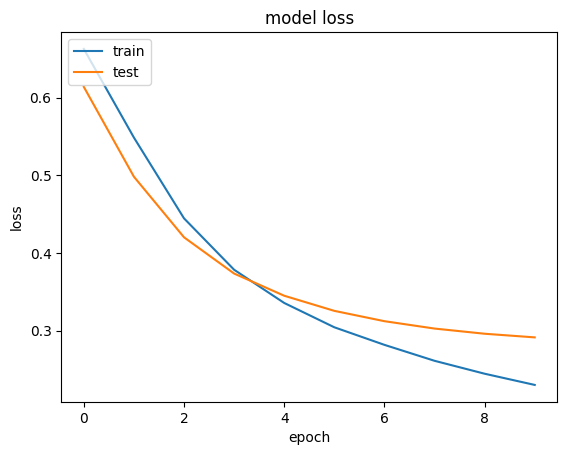

In [25]:
# prompt: narysuj wykres zależności numeru epoki od funkcji straty - loss

import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [26]:
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy'])

loss,accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 4s 4ms/step - loss: 0.3099 - accuracy: 0.8742
0.8741999864578247


In [29]:
testy = [
    "The movie was great!",
    "The movie was okay.",
    "The movie was terrible.",
    "Very bad movie!",
    "bad movie!",
    "Big Shit!",
    "Disaster.",
    "Beautiful disaster",
    "Głupi film.",
    "The movie was bad bad bad bad bad bad",
    "The movie was okay okay okay okay okay okay okay okay.",
    "Great Great Great Great Great Great Great",
    "The movie was good with good acting but a poor screenplay."
]

In [30]:
export_model.predict(testy)

1/1 [==============================] - 0s 38ms/step


array([[0.64225125],
       [0.46746525],
       [0.38135904],
       [0.43807092],
       [0.39977452],
       [0.55030364],
       [0.48676354],
       [0.578667  ],
       [0.54590976],
       [0.03735946],
       [0.1456014 ],
       [0.9718164 ],
       [0.3583607 ]], dtype=float32)